In [1]:
!pip install pyGPGO

In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
n_start_AcqFunc = 250 #multi-start iterations to avoid local optima in AcqFunc optimization

In [4]:
### Data inputs:
set_seed = 888 #initialise pseudo-random number generator, same start-point each time.

### Acquisition / Utility function - MLE/Type II:
d_util = 'dEI_GP'
d_util_new = 'dEI_STP'

n_test = n_start_AcqFunc
opt=False

In [5]:
### Objective Function - Sin(x) 1-D:

eps = 1e-8

def f_sine(x1_training):
    return operator * np.sin(x1_training)
        
def f_sine_eps(x1_training):
    return operator * np.sin(x1_training + eps)

# Constraints:
lb = 0
ub = 2 * np.pi
    
# Input array dimension(s):
dim = 1

# 1-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub])}
    
# True y bounds:
y_lb = 1 # targets global maximum 
operator = 1 # targets global maximum 
y_global_orig = y_lb * operator # targets global maximum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)

In [6]:
### Derivatives - Squared-exponential covariance function:

def l2norm_(X, Xstar):
    
    return cdist(X, Xstar)

def kronDelta(X, Xstar):

    return cdist(X, Xstar) < np.finfo(np.float32).eps

class squaredExponentialDeriv(squaredExponential):
    l = 1
    sigmaf = 1e-4
    sigman = 1e-6

    def K(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        K = self.sigmaf * np.exp(-1/2*r **2) + self.sigman * kronDelta(X, Xstar)
        return K
    
    def dK(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        dK = self.sigmaf/self.l**2 * np.exp(-1/2 * r **2) * l2norm_(X, Xstar)
        return dK
    
    def d2K(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        d2K = self.sigmaf/self.l**2 * np.exp(-1/2 * r **2) * (r **2 - 1)
        return d2K
    
cov_func_gp = squaredExponentialDeriv()
cov_func_stp = squaredExponentialDeriv()

In [7]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-08, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP,
            'dEI_STP': self.dEI_STP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
        z = -1 * (tau - mean - self.eps) / (std + self.eps)
        
        dsdx = ds / 2 * (std + self.eps)
        d2sdx = -dsdx**2 / ((std + self.eps)) - dvdv / (std + self.eps) - d2v / (std + self.eps)
        dmdx = (dm - z * dsdx) / (std + self.eps)
        d2mdx = (d2m - (z * d2sdx + 2 * dmdx * dsdx)) / (std + self.eps)
        
        f = (std + self.eps) * (z * norm.cdf(z) + norm.pdf(z)[0])
        df = (f / (std + self.eps) * dsdx + (std + self.eps) * norm.cdf(z) * dmdx)
        d2f = (f / (std + self.eps) * d2sdx + dsdx * dmdx * norm.cdf(z) \
            + d2mdx * (std + self.eps) * norm.cdf(z) + dsdx * norm.cdf(z) * dmdx \
            + norm.pdf(z)[0] * (std + self.eps) * dmdx)
            
        return f, df, d2f

    def dEI_STP(self, tau, mean, std, ds, dm, dvdv, d2v, d2m, nu=3.0):
    
        gamma = -1 * (tau - mean - self.eps) / (std + self.eps)
        dsdx = ds / (std + self.eps)
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        f = (std + self.eps) * (gamma * t.cdf(gamma, df=nu) + (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu))
        df = (gamma * t.cdf(gamma, df=nu) + (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma,df=nu)[0]) * dsdx \
             + (std + self.eps) * (t.cdf(gamma,df=nu) * dmdx + gamma * t.pdf(gamma, df=nu) * \
             (1 - (nu + gamma ** 2)/(nu - 1) + 2/(nu - 1) * dmdx))
        return f, df
    
    def _eval(self, tau, mean, std):
    
        return self.f(tau, mean, std, **self.params)
    
    def d_eval(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
    
        return self.f(tau, mean, std, ds, dm, dvdv, d2v, d2m, **self.params)

    def d_eval_stp(self, tau, mean, std, ds, dm, dvdv, d2v, d2m, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, dvdv, d2v, d2m, nu=3.0, **self.params)

In [9]:
### Surrogate derivatives: 

from scipy.linalg import cholesky, solve

class dGaussianProcess(GaussianProcess):
    l = 1
    sigmaf = 1e-4
    sigman = 1e-6

    def AcqGrad(self, Xstar, return_std=False):
        r_X = l2norm_(self.X, self.X)/self.l
        K = self.sigmaf * np.exp(-1/2*r_X **2) + self.sigman * kronDelta(self.X, self.X)
        L = cholesky(K).T
        alpha = solve(L.T, solve(L, self.y))
        Xstar = np.atleast_2d(Xstar)
        Kstar = squaredExponentialDeriv.K(self, self.X, Xstar).T
        dKstar = squaredExponentialDeriv.dK(self, self.X, Xstar).T
        d2Kstar = squaredExponentialDeriv.d2K(self, self.X, Xstar).T
        v = solve(self.L, Kstar.T)
        dv = solve(self.L, dKstar.T)
        d2v = solve(self.L, d2Kstar.T)
        
        ds = -2 * np.dot(dv.T, v)
        dvdv = np.dot(dv.T, dv)
        d2s = -2 * (dvdv + d2v)
        
        dm = np.dot(dKstar, alpha)
        d2m = np.dot(d2Kstar, alpha)
        return ds, dm, dvdv, d2v, d2m

class dtStudentProcess(tStudentProcess):
    l = 1
    sigmaf = 1e-4
    sigman = 1e-6
    
    def AcqGrad(self, Xstar, return_std=False):
        r_X = l2norm_(self.X, self.X)/self.l
        K = self.sigmaf * np.exp(-1/2*r_X **2) + self.sigman * kronDelta(self.X, self.X)
        L = cholesky(K).T
        alpha = solve(L.T, solve(L, self.y))
        Xstar = np.atleast_2d(Xstar)
        Kstar = squaredExponentialDeriv.K(self, self.X, Xstar).T
        dKstar = squaredExponentialDeriv.dK(self, self.X, Xstar).T
        d2Kstar = squaredExponentialDeriv.d2K(self, self.X, Xstar).T
        v = solve(L, Kstar.T)
        dv = solve(L, dKstar.T)
        d2v = solve(L, d2Kstar.T)

        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)
        
        ds = -2 * smd_adj * np.dot(dv.T, v)
        dvdv = np.dot(dv.T, dv)
        d2s = -2 * smd_adj * (dvdv + d2v)
        
        dm = np.dot(dKstar, alpha)
        d2m = np.dot(d2Kstar, alpha)
        return ds, dm, dvdv, d2v, d2m

In [10]:
class dGPGO(GPGO):  
    n_start = n_start_AcqFunc
    eps = 1e-08
        
    def func(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[0]
        df = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
        
    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

In [11]:
## dGPGO_stp - BayesOpt derivatives' class: Student's-t

class dGPGO_stp(GPGO):  
    n_start = 100
        
    def func_stp(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m, nu=df)[0]
        df = -self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m, nu=df)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
        
    def d_optimizeAcq_stp(self, method='L-BFGS-B', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func_stp,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq_stp()
            self.updateGP()
            self.logger._printCurrent(self)

In [12]:
### d2GPGO - BayesOpt class: Exact Hessian

class d2GPGO(GPGO):  
    n_start = n_start_AcqFunc
    p = np.full((n_start,1),1) + 1
    eps = 1e-08
    
    def func(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[0]
        df = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
    
    def hessp_nonzero(self, xnew, p):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
        df2 = np.empty((self.n_start,))
        df2 = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[2]
        H2 = np.empty((self.n_start,))
        df2 = np.asarray(df2)
        p = np.asarray(p)
        H2 = np.multiply(df2,p)
        return H2

    def dEI_GP(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
        z = -1 * (tau - mean - self.eps) / (std + self.eps)
        
        dsdx = ds / 2 * (std + self.eps)
        d2sdx = -dsdx**2 / ((std + self.eps)) - dvdv / (std + self.eps) - d2v / (std + self.eps)
        dmdx = (dm - z * dsdx) / (std + self.eps)
        d2mdx = (d2m - (z * d2sdx + 2 * dmdx * dsdx)) / (std + self.eps)
        
        d2f = (z * norm.cdf(z) + norm.pdf(z)[0]) * d2sdx + dsdx * dmdx * norm.cdf(z) \
            + d2mdx * (std + self.eps) * norm.cdf(z) + dsdx * norm.cdf(z) * dmdx \
            + norm.pdf(z)[0] * (std + self.eps) * dmdx

        return d2f

    def hessp_nonzero1(self, xnew, p, *args):
      new_mean, new_var = self.GP.predict(xnew, return_std=True)
      new_std = np.sqrt(new_var + 1e-6)
      ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
      df2 = np.empty((self.n_start,))
      df2 = -self.dEI_GP(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[0] * p
      return df2

    def d_optimizeAcq(self, method='Newton-CG', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,                  
                                                                 hessp = self.hessp_nonzero1,                      
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]

    def run(self, max_iter=10, init_evals=3, resume=False):    
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

In [13]:
n_init = 2  # Number of iterations used to initialise Bayesian optimisation; minimum 2
iters = 2

In [14]:
np.random.seed(set_seed)

gp_iters = dGaussianProcess(cov_func_gp, optimize=opt)
gpgo_iters = dGPGO(gp_iters, Acquisition_new(d_util), f_sine, param)
gpgo_iters.run(init_evals=n_init, max_iter=iters)

x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
a_iters = np.array(-gpgo_iters.f_best.flatten())
max(a_iters), gpgo_iters.best[0]

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.40077857]. 	  -0.7722701001578773 	 0.8593619530727911
init   	 [1.03402064]. 	  0.8593619530727911 	 0.8593619530727911
1      	 [0.06067612]. 	  0.06063889401347421 	 0.8593619530727911
2      	 [1.92662017]. 	  0.9373598108361146 	 0.9373598108361146


(0.22319756235962154, 1.9266201695880354)

In [15]:
np.random.seed(set_seed)

stp_iters = dtStudentProcess(cov_func_stp, optimize=opt)
stpgo_iters = dGPGO_stp(stp_iters, Acquisition_new(d_util_new), f_sine, param)
stpgo_iters.run(init_evals=n_init, max_iter=iters)

x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
a_stp_iters = np.array(-stpgo_iters.f_best.flatten())
max(a_stp_iters), stpgo_iters.best[0]

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.40077857]. 	  -0.7722701001578773 	 0.8593619530727911
init   	 [1.03402064]. 	  0.8593619530727911 	 0.8593619530727911
1      	 [2.16589522]. 	  0.8280930620851258 	 0.8593619530727911
2      	 [0.19620746]. 	  0.19495096493145758 	 0.8593619530727911


(0.14835854396395473, 0.19620745560536307)

In [16]:
np.random.seed(set_seed)

gp_iters1 = dGaussianProcess(cov_func_gp, optimize=opt)
gpgo_iters1 = dGPGO(gp_iters1, Acquisition_new(d_util), f_sine, param)
gpgo_iters1.run(init_evals=n_init, max_iter=iters+1)

x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
a_iters1 = np.array(-gpgo_iters1.f_best.flatten())
max(a_iters1), gpgo_iters1.best[0]

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.40077857]. 	  -0.7722701001578773 	 0.8593619530727911
init   	 [1.03402064]. 	  0.8593619530727911 	 0.8593619530727911
1      	 [0.06067612]. 	  0.06063889401347421 	 0.8593619530727911
2      	 [1.92662017]. 	  0.9373598108361146 	 0.9373598108361146
3      	 [1.53628526]. 	  0.9994045523613151 	 0.9994045523613151


(0.09347177015346617, 1.5362852636107074)

In [17]:
np.random.seed(set_seed)

stp_iters1 = dtStudentProcess(cov_func_stp, optimize=opt)
stpgo_iters1 = dGPGO_stp(stp_iters1, Acquisition_new(d_util_new), f_sine, param)
stpgo_iters1.run(init_evals=n_init, max_iter=iters+1)

x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
a_stp_iters1 = np.array(-stpgo_iters1.f_best.flatten())
max(a_stp_iters1), stpgo_iters1.best[0]

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.40077857]. 	  -0.7722701001578773 	 0.8593619530727911
init   	 [1.03402064]. 	  0.8593619530727911 	 0.8593619530727911
1      	 [2.16589522]. 	  0.8280930620851258 	 0.8593619530727911
2      	 [0.19620746]. 	  0.19495096493145758 	 0.8593619530727911
3      	 [1.57205284]. 	  0.9999992105918857 	 0.9999992105918857


(0.17214771792693775, 1.5720528364194017)

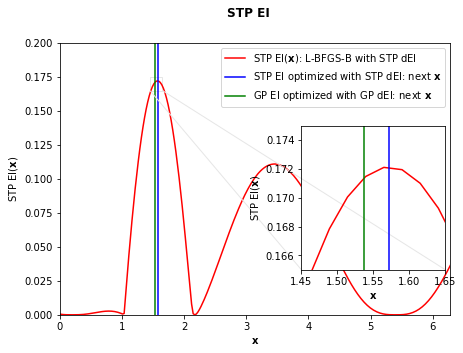

(0.17211236178013364, 7.781580042440963e-10)

In [18]:
def plot_dGPGO(gpgo, param, new):
    fig, ax = plt.subplots(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    a = np.array([-stpgo_iters.func_stp(np.atleast_1d(x))[0] for x in x_test]).flatten()
    plt.plot(x_test, a, color='r', label='STP EI$(\mathbf{x})$: L-BFGS-B with STP dEI')
    plt.ylim(0, 0.2)
    plt.xlim(0, 2 * np.pi)
    plt.axvline(stpgo_iters1.best[0], color='b', label='STP EI optimized with STP dEI: next $\mathbf{x}$')
    plt.axvline(gpgo_iters1.best[0], color='g', label='GP EI optimized with GP dEI: next $\mathbf{x}$')
    plt.legend(loc=1)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("STP EI$(\mathbf{x})$")
    title = 'STP EI'
    plt.suptitle(title, weight = 'bold')

    axins = inset_axes(ax, 2, 2, loc=7, bbox_to_anchor=(0.9, 0.45),bbox_transform=ax.figure.transFigure) # no zoom
    axins.plot(x_test[0:], a[0:], color='r', label='STP EI$(\mathbf{x})$: excl. Hessian')
    axins.set_ylim(0.165, 0.175)
    axins.set_xlim(1.45, 1.65) # Limit the region for zoom
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("STP EI$(\mathbf{x})$")
    axins.set_autoscaley_on(True)
    plt.axvline(stpgo_iters1.best[0], color='b', label='STP EI optimized with STP dEI$(\mathbf{x})$: next $\mathbf{x}$')
    plt.axvline(gpgo_iters1.best[0], color='g', label='GP EI optimized with GP dEI$(\mathbf{x})$: next $\mathbf{x}$')
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.9")
    plt.draw()
    plt.show()
    return max(a), min(a)

plot_dGPGO(stpgo_iters, param, new=True)

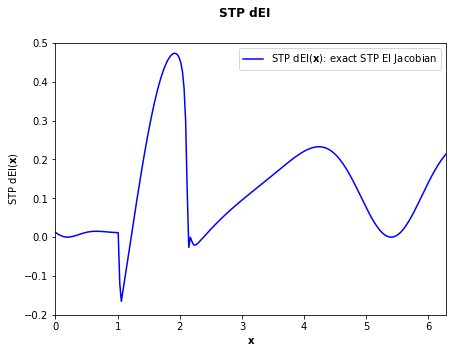

(250, -0.16529079065414035, 0.47361184650361426)

In [24]:
def plot_jacobian(gpgo_iters, param, new):
    plt.figure(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    jac_stp = np.array([-stpgo_iters.func_stp(np.atleast_1d(x))[1] for x in x_test]).flatten()
    plt.plot(x_test, jac_stp, color='b', label='STP dEI$(\mathbf{x})$: exact STP EI Jacobian')
    plt.ylim(-0.2, 0.5)
    plt.xlim(0, 2 * np.pi)
    plt.legend(loc=0)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("STP dEI$(\mathbf{x})$")
    title = 'STP dEI'
    plt.suptitle(title, weight = 'bold')    
    plt.show()
    return len(jac_stp), min(jac_stp), max(jac_stp)
  
plot_jacobian(stpgo_iters, param, new=True)

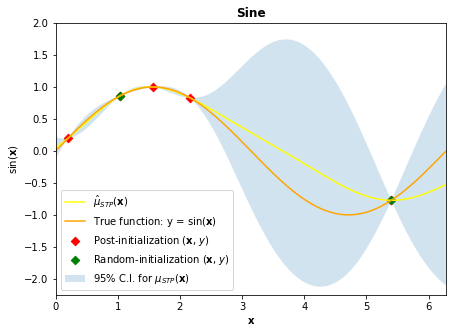

In [20]:
def plot_sine(gpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    y_hat, y_var = gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 3.182 * std, y_hat + 3.182 * std # t-score (nu = 3), 95% confidence (two-tail)
    colours = ['Post', 'Random']
    if new:
        plt.figure(figsize=[7,5])
        plt.scatter(gpgo.GP.X, gpgo.GP.y, marker ='D', color = 'Red', label='Post-initialization ($\mathbf{x}$, $y$)')
        plt.scatter(gpgo.X, gpgo.y, marker ='D', color = 'Green', label='Random-initialization ($\mathbf{x}$, $y$)')
        plt.ylim(-2.25,2)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), y_hat, color = 'Yellow', label='$\hat{\mu}_{STP}(\mathbf{x})$')
        plt.plot(x_test.flatten(), np.sin(x_test.flatten()), color = 'Orange', label='True function: y = sin($\mathbf{x}$)')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% C.I. for $\mu_{STP}(\mathbf{x})$')
        title = 'Sine'
        plt.title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$)")
        plt.legend(loc=3)
        plt.show()

plot_sine(stpgo_iters1, param, new=True)

In [21]:
y_global_opt = 1

In [22]:
gpgo_iters1.tau, stpgo_iters1.tau

(0.9994045523613151, 0.9999992105918857)

In [23]:
gpgo_iters1_regret = y_global_opt - gpgo_iters1.tau
stpgo_iters1_regret = y_global_opt - stpgo_iters1.tau

gpgo_iters1_regret, stpgo_iters1_regret, 

(0.0005954476386849095, 7.894081143211551e-07)